In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb
from pathlib import Path
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [4]:
print("🚀 STARTING HONEST VALIDATION PIPELINE...")
BASE_DIR = Path("./PS2-SIH25/ML").resolve()
ARTIFACT_DIR = BASE_DIR / "artifacts"
DATA_DIR = BASE_DIR / "Data_SIH_2025 2"
VALIDATION_DIR = ARTIFACT_DIR / "VALIDATION_MODELS"
VALIDATION_DIR.mkdir(parents=True, exist_ok=True)

# Input Files
ENGINEERED_DATA_PATH = DATA_DIR / "train_dataset_engineered.csv"
ERA5_DATA_PATH = DATA_DIR / "era5_station_timeseries.csv"


🚀 STARTING HONEST VALIDATION PIPELINE...


In [5]:
print("\n[1/5] Loading datasets...")
if not ENGINEERED_DATA_PATH.exists():
    raise FileNotFoundError(f"Missing {ENGINEERED_DATA_PATH}")
if not ERA5_DATA_PATH.exists():
    raise FileNotFoundError(f"Missing {ERA5_DATA_PATH}")

# Load & Fix Datetime
df_eng = pd.read_csv(ENGINEERED_DATA_PATH)
df_eng["datetime"] = pd.to_datetime(df_eng["datetime"])

df_era5 = pd.read_csv(ERA5_DATA_PATH)
df_era5["datetime"] = pd.to_datetime(df_era5["datetime"])

# Merge (Left Join)
print(f"Merging Engineered ({len(df_eng)}) + ERA5 ({len(df_era5)})...")
df = df_eng.merge(df_era5, on=["site", "datetime"], how="left")
df = df.sort_values(["site", "datetime"]).reset_index(drop=True)


[1/5] Loading datasets...
Merging Engineered (171511) + ERA5 (306936)...
Merging Engineered (171511) + ERA5 (306936)...


In [ ]:
df.columns

Index(['year', 'month', 'day', 'hour', 'O3_forecast', 'NO2_forecast',
       'T_forecast', 'q_forecast', 'u_forecast', 'v_forecast', 'w_forecast',
       'NO2_satellite', 'HCHO_satellite', 'ratio_satellite', 'O3_target',
       'NO2_target', 'site', 'lat', 'lon', 'datetime', 'O3_lag_1h',
       'NO2_lag_1h', 'O3_lag_3h', 'NO2_lag_3h', 'O3_lag_6h', 'NO2_lag_6h',
       'O3_lag_12h', 'NO2_lag_12h', 'O3_lag_24h', 'NO2_lag_24h',
       'O3_roll24_mean', 'NO2_roll24_mean', 'O3_city_mean_lag1',
       'O3_city_std_lag1', 'NO2_city_mean_lag1', 'NO2_city_std_lag1',
       'O3_idw_lag1', 'NO2_idw_lag1', 'O3_diff_mean_lag1',
       'NO2_diff_mean_lag1', 'hour_sin', 'hour_cos', 'month_sin', 'month_cos',
       'wind_speed', 'O3_forecast_x_wind', 'NO2_forecast_x_wind',
       'NO2_to_HCHO_ratio', 'era5_blh', 'era5_tcc', 'era5_t2m', 'era5_d2m',
       'era5_ssrd', 'era5_tp'],
      dtype='object')

In [6]:
print("\n[2/5] Splitting Data...")
# 🚨 CRITICAL: Train on Past (2019-2023), Test on Future (2024)
train_df = df[df["year"] < 2024].copy()
test_df  = df[df["year"] == 2024].copy()

print(f"Training Rows (2019-2023): {len(train_df)}")
print(f"Testing Rows  (2024):      {len(test_df)}")

if test_df.empty:
    raise ValueError("❌ No 2024 data found! Cannot proceed with evaluation.")




[2/5] Splitting Data...
Training Rows (2019-2023): 155232
Testing Rows  (2024):      16279


In [7]:
feature_cols = [
    # Forecast & Satellite
    "O3_forecast", "NO2_forecast",
    "T_forecast", "q_forecast", "u_forecast", "v_forecast", "w_forecast",
    "NO2_satellite", "HCHO_satellite", "ratio_satellite", "NO2_to_HCHO_ratio",

    # Lags (History)
    "O3_lag_1h", "O3_lag_3h", "O3_lag_6h", "O3_lag_12h", "O3_lag_24h",
    "NO2_lag_1h", "NO2_lag_3h", "NO2_lag_6h", "NO2_lag_12h", "NO2_lag_24h",

    # Rolling Means (Shifted/Honest)
    "O3_roll24_mean", "NO2_roll24_mean",

    # Time & Interactions
    "hour_sin", "hour_cos", "month_sin", "month_cos",
    "wind_speed", "O3_forecast_x_wind", "NO2_forecast_x_wind",

    # Spatial & Coords
    "lat", "lon", "site",
    "O3_city_mean_lag1", "O3_city_std_lag1",
    "NO2_city_mean_lag1", "NO2_city_std_lag1",
    "O3_idw_lag1", "NO2_idw_lag1",
    "O3_diff_mean_lag1", "NO2_diff_mean_lag1",

    # ERA5 Weather
    "era5_blh", "era5_tcc", "era5_t2m", "era5_d2m", "era5_ssrd", "era5_tp"
]

X_train = train_df[feature_cols]
X_test  = test_df[feature_cols]

In [8]:
print("\n[3/5] Training XGBoost Models (Single Stage ERA5-Enhanced)...")

params = {
    "n_estimators": 500, "max_depth": 9, "learning_rate": 0.03,
    "subsample": 0.8, "colsample_bytree": 0.9, "objective": "reg:squarederror",
    "n_jobs": -1, "random_state": 42
}

# --- O3 ---
print("Training O3...")
model_O3 = xgb.XGBRegressor(**params)
model_O3.fit(X_train, train_df["O3_target"])
model_O3.save_model(VALIDATION_DIR / "val_O3.json")

# --- NO2 ---
print("Training NO2...")
model_NO2 = xgb.XGBRegressor(**params)
model_NO2.fit(X_train, train_df["NO2_target"])
model_NO2.save_model(VALIDATION_DIR / "val_NO2.json")



[3/5] Training XGBoost Models (Single Stage ERA5-Enhanced)...
Training O3...
Training NO2...


In [10]:
print("\n[4/5] Evaluating on 2024 Test Set...")

test_df["O3_pred"] = model_O3.predict(X_test)
test_df["NO2_pred"] = model_NO2.predict(X_test)

def print_metrics(y_true, y_pred, label):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    print(f"--- {label} ---")
    print(f"RMSE : {rmse:.3f}")
    print(f"MAE  : {mae:.3f}")
    print(f"R²   : {r2:.4f}")


[4/5] Evaluating on 2024 Test Set...


In [ ]:
print("\n" + "="*40)
print("✅ FINAL HONEST SCORES (Test Year: 2024)")
print("="*40)
print_metrics(test_df["O3_target"], test_df["O3_pred"], "OZONE (O3)")
print("-" * 20)
print_metrics(test_df["NO2_target"], test_df["NO2_pred"], "NITROGEN DIOXIDE (NO2)")
print("="*40)


✅ FINAL HONEST SCORES (Test Year: 2024)
--- OZONE (O3) ---
RMSE : 9.776
MAE  : 6.116
R²   : 0.9473
--------------------
--- NITROGEN DIOXIDE (NO2) ---
RMSE : 11.026
MAE  : 6.884
R²   : 0.8727



[5/5] Generating Plot...


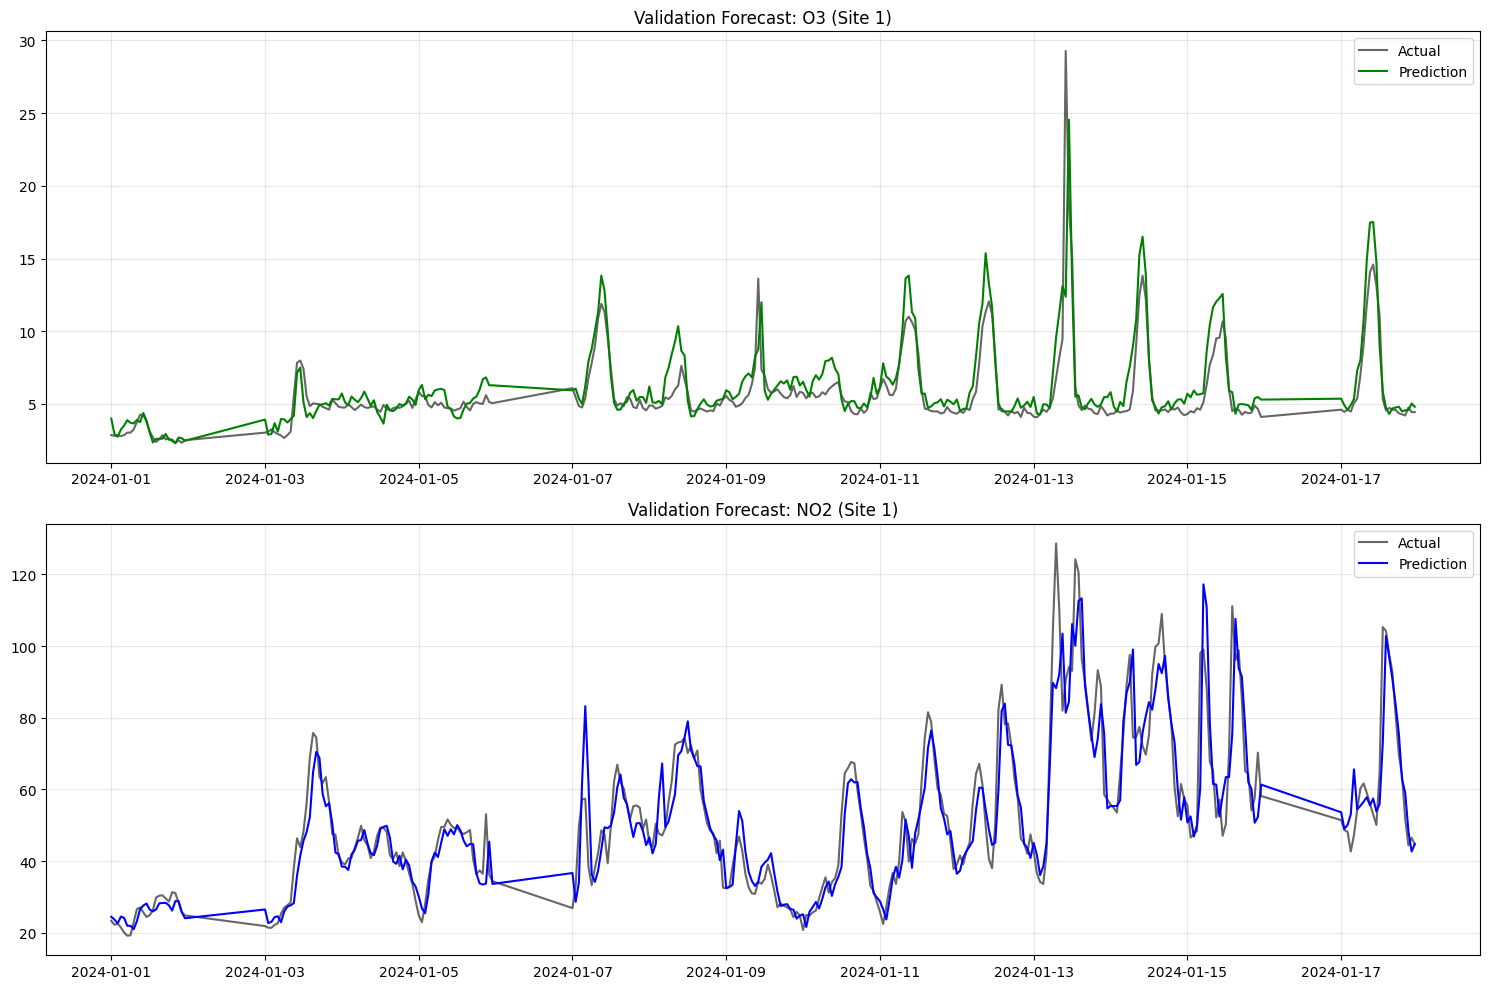


✨ Process Complete.


In [ ]:
print("\n[5/5] Generating Plot...")
site_id = sorted(test_df["site"].unique())[0]
plot_data = test_df[test_df["site"] == site_id].sort_values("datetime").iloc[:336] # 2 weeks

plt.figure(figsize=(15, 10))

# O3 Plot
plt.subplot(2, 1, 1)
plt.plot(plot_data["datetime"], plot_data["O3_target"], 'k-', label='Actual', alpha=0.6)
plt.plot(plot_data["datetime"], plot_data["O3_pred"], 'g-', label='Prediction', linewidth=1.5)
plt.title(f"Validation Forecast: O3 (Site {site_id})")
plt.legend()
plt.grid(True, alpha=0.3)

# NO2 Plot
plt.subplot(2, 1, 2)
plt.plot(plot_data["datetime"], plot_data["NO2_target"], 'k-', label='Actual', alpha=0.6)
plt.plot(plot_data["datetime"], plot_data["NO2_pred"], 'b-', label='Prediction', linewidth=1.5)
plt.title(f"Validation Forecast: NO2 (Site {site_id})")
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()
print("\n✨ Process Complete.")

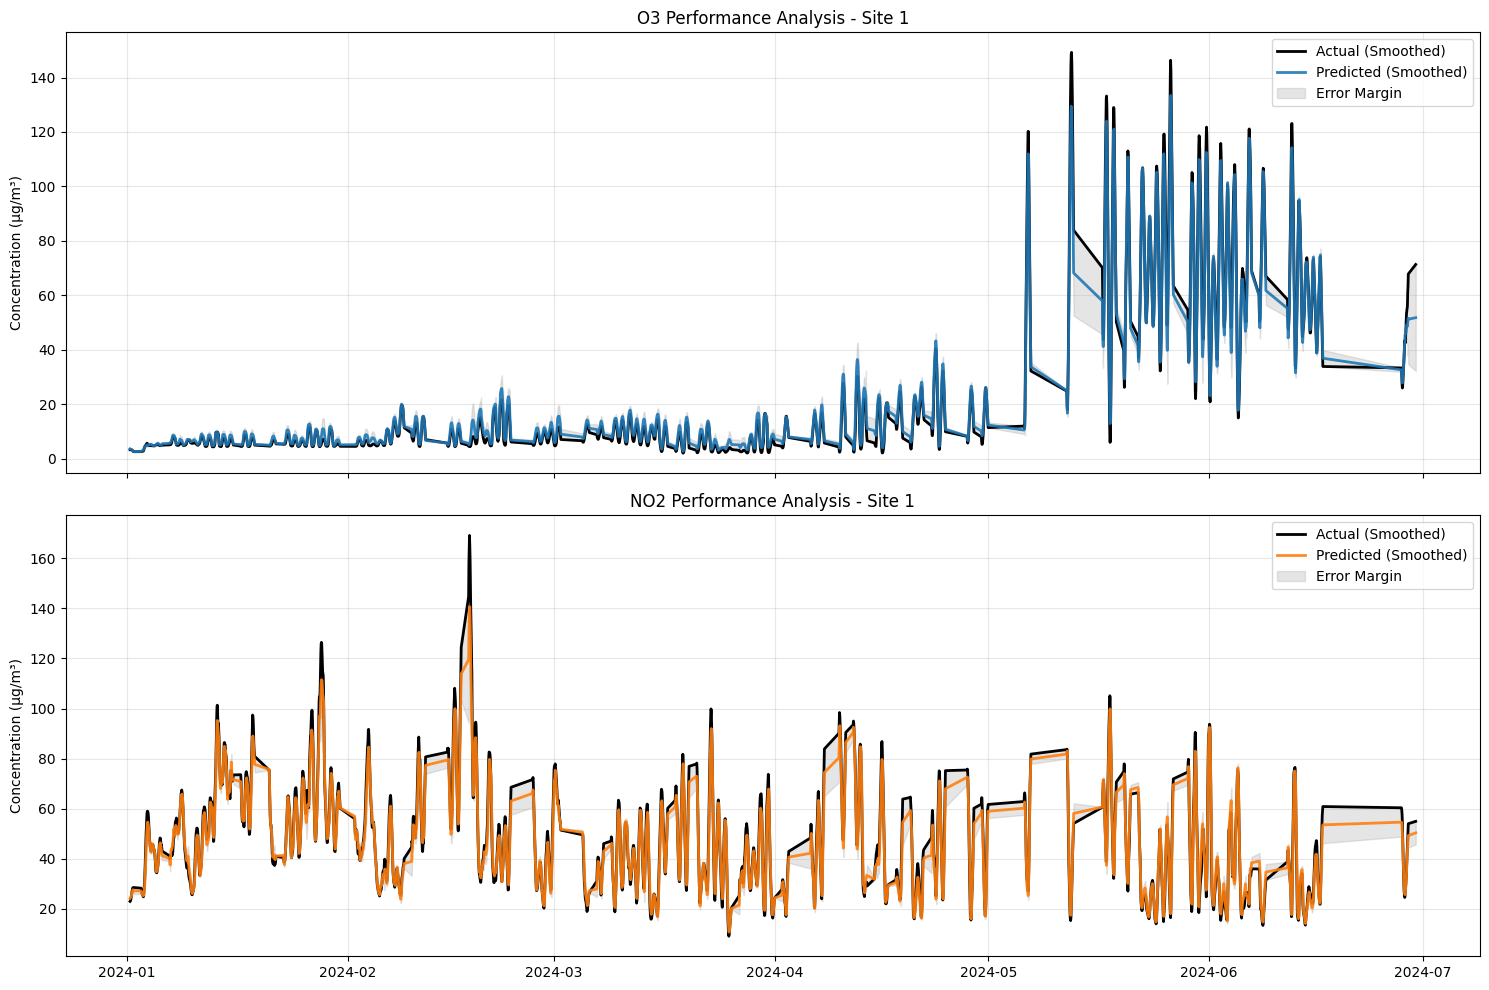

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# CONFIG
SITE_ID = 1  # Change to check different sites
WINDOW = 12  # 12-hour smoothing for clearer visuals

# Filter Data
plot_df = test_df[test_df["site"] == SITE_ID].copy()
plot_df = plot_df.set_index("datetime").sort_index()

# Create 2 Plots (O3 and NO2)
fig, axes = plt.subplots(2, 1, figsize=(15, 10), sharex=True)

for i, gas in enumerate(["O3", "NO2"]):
    # Calculate Rolling Means
    actual = plot_df[f"{gas}_target"].rolling(WINDOW).mean()
    pred = plot_df[f"{gas}_pred"].rolling(WINDOW).mean()
    error = (pred - actual).abs()

    # Plot Lines
    axes[i].plot(plot_df.index, actual, label="Actual (Smoothed)", color='black', linewidth=2)
    axes[i].plot(plot_df.index, pred, label="Predicted (Smoothed)", color='tab:blue' if i==0 else 'tab:orange', linewidth=2, alpha=0.9)

    # Plot Error Band
    axes[i].fill_between(plot_df.index, pred - error, pred + error, color='gray', alpha=0.2, label="Error Margin")

    axes[i].set_title(f"{gas} Performance Analysis - Site {SITE_ID}")
    axes[i].set_ylabel("Concentration (µg/m³)")
    axes[i].legend()
    axes[i].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

/tmp/ipython-input-2341569182.py:7: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  resampled = site_data.resample(FREQ).mean()


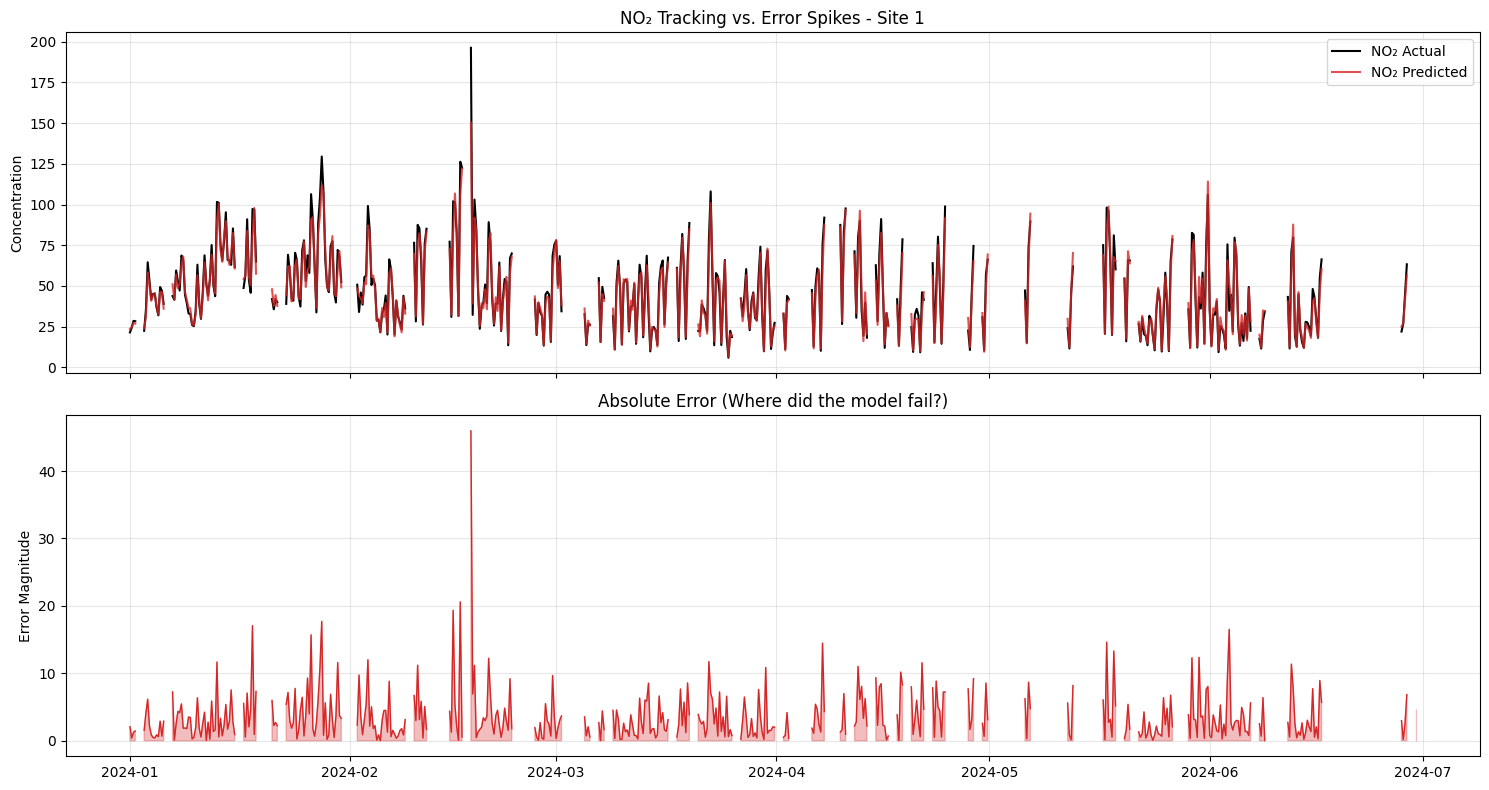

In [ ]:
# CONFIG
SITE_ID = 1
FREQ = "6H" # Resample to 6H to reduce noise but keep detail

site_data = test_df[test_df["site"] == SITE_ID].copy()
site_data = site_data.set_index("datetime").sort_index()
resampled = site_data.resample(FREQ).mean()

fig, axes = plt.subplots(2, 1, figsize=(15, 8), sharex=True)

# --- Top: NO2 Performance (Focusing on NO2 since it has sudden spikes) ---
axes[0].plot(resampled.index, resampled["NO2_target"], label="NO₂ Actual", color='black', linewidth=1.5)
axes[0].plot(resampled.index, resampled["NO2_pred"], label="NO₂ Predicted", color='tab:red', linewidth=1.5, alpha=0.8)
axes[0].set_title(f"NO₂ Tracking vs. Error Spikes - Site {SITE_ID}")
axes[0].set_ylabel("Concentration")
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# --- Bottom: The Error Spike Detector ---
error = (resampled["NO2_pred"] - resampled["NO2_target"]).abs()
axes[1].plot(resampled.index, error, color='tab:red', linewidth=1)
axes[1].fill_between(resampled.index, 0, error, color='tab:red', alpha=0.3)
axes[1].set_title("Absolute Error (Where did the model fail?)")
axes[1].set_ylabel("Error Magnitude")
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()